In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize 
nltk.download('stopwords'); nltk.download('punkt'); nltk.download('wordnet'); nltk.download('omw-1.4')
import re
import string


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [111]:
columns = ["target", "id", "date", "flag", "user", "text"] 
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding='latin-1', names=columns)


df = df[df['target'].isin([0, 4])]


sample_per_class = 100000

df = pd.concat([
    df[df['target']==0].sample(sample_per_class, random_state=42),
    df[df['target']==4].sample(sample_per_class, random_state=42)
])


df = df.reset_index(drop=True)


df.to_csv("balanced_sentiment140_no_neutral.csv", index=False)

print("new data set for  my project ")

label_map = {0:'negative',2:'neutral',4:'positive'}
df['label'] = df['target'].map(label_map).fillna(df['target'])
print(df[['text','label']].head())
print(df[['text','label']].tail())



new data set for  my project 
                                                text     label
0  @xnausikaax oh no! where did u order from? tha...  negative
1  A great hard training weekend is over.  a coup...  negative
2  Right, off to work  Only 5 hours to go until I...  negative
3                    I am craving for japanese food   negative
4  Jean Michel Jarre concert tomorrow  gotta work...  negative
                                                     text     label
199995  @kimberlykeith Awww thanks  That made me feel ...  positive
199996  @callkathy I just started using this on my iPh...  positive
199997  @tferriss Hi Tim, what are your thoughts of Bu...  positive
199998  @pastorjpruitt We have authority over devils (...  positive
199999  @greaggedeanman, the one with ''saving the wor...  positive


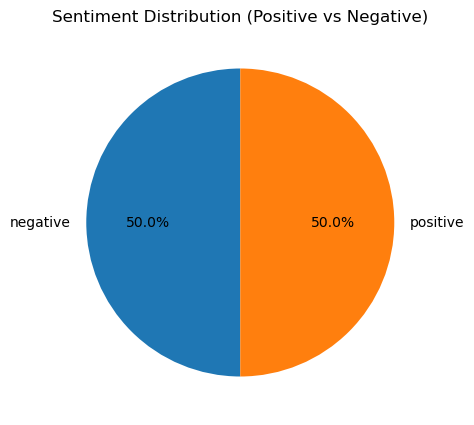

In [113]:
counts = df['label'].value_counts()

plt.figure(figsize=(5,5))
plt.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Sentiment Distribution (Positive vs Negative)')
plt.show()


In [115]:

print("Null values per column:")
print(df.isnull().sum())


df = df.dropna(subset=['text', 'target'])

print("Dataset ok. final rows:", len(df))


Null values per column:
target    0
id        0
date      0
flag      0
user      0
text      0
label     0
dtype: int64
Dataset ok. final rows: 200000


In [117]:
df['text_lower'] = df['text'].str.lower()
print (df['text_lower'].head())

0    @xnausikaax oh no! where did u order from? tha...
1    a great hard training weekend is over.  a coup...
2    right, off to work  only 5 hours to go until i...
3                      i am craving for japanese food 
4    jean michel jarre concert tomorrow  gotta work...
Name: text_lower, dtype: object


In [119]:
def clean_text(text):
    text = re.sub(r"http\S+", "", text)        
    text = re.sub(r"@\w+", "", text)           
    text = re.sub(r"#\w+", "", text)           
    text = re.sub(r"[^a-zA-Z\s]", "", text)    
    text = re.sub(r"\s+", " ", text).strip()   
    return text

df["clean_text"] = df["text_lower"].apply(clean_text)
print(df[['clean_text']].head())

                                          clean_text
0        oh no where did u order from thats horrible
1  a great hard training weekend is over a couple...
2  right off to work only hours to go until im fr...
3                     i am craving for japanese food
4  jean michel jarre concert tomorrow gotta work ...


In [121]:
df['text_nopunct'] = df['clean_text'].apply(lambda x: re.sub(f"[{re.escape(string.punctuation)}]", "", x))

print(df[['text_nopunct']].head())


                                        text_nopunct
0        oh no where did u order from thats horrible
1  a great hard training weekend is over a couple...
2  right off to work only hours to go until im fr...
3                     i am craving for japanese food
4  jean michel jarre concert tomorrow gotta work ...


In [123]:
df['tokens'] = df['text_nopunct'].apply(word_tokenize)
print(df[['tokens']].head())



                                              tokens
0  [oh, no, where, did, u, order, from, thats, ho...
1  [a, great, hard, training, weekend, is, over, ...
2  [right, off, to, work, only, hours, to, go, un...
3              [i, am, craving, for, japanese, food]
4  [jean, michel, jarre, concert, tomorrow, got, ...


In [125]:
stop_words = set(stopwords.words('english'))
df['tokens_nostop'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
print(df[['tokens_nostop']].head())


                                       tokens_nostop
0                    [oh, u, order, thats, horrible]
1  [great, hard, training, weekend, couple, days,...
2             [right, work, hours, go, im, free, xd]
3                          [craving, japanese, food]
4  [jean, michel, jarre, concert, tomorrow, got, ...


In [127]:
def synonym_sub(tokens):
    out = []
    for w in tokens:
        syns = wordnet.synsets(w)
        if syns:
            lemmas = syns[0].lemmas()
            if lemmas:
                out.append(lemmas[0].name().replace('_',' '))
            else:
                out.append(w)
        else:
            out.append(w)
    return out

df['tok_syn'] = df['tokens_nostop'].apply(synonym_sub)
print(df[['tok_syn']].head())



                                             tok_syn
0            [Ohio, uracil, order, thats, atrocious]
1  [great, difficult, training, weekend, couple, ...
2             [right, work, hours, go, im, free, xd]
3                          [craving, Japanese, food]
4  [jean, michel, jarre, concert, tomorrow, get, ...


In [129]:
stemmer = PorterStemmer()
df['tok_stem'] = df['tok_syn'].apply(lambda toks: [stemmer.stem(w) for w in toks])
df[['tok_stem']].head()

,tok_stem
0,"[ohio, uracil, order, that, atroci]"
1,"[great, difficult, train, weekend, coupl, day,..."
2,"[right, work, hour, go, im, free, xd]"
3,"[crave, japanes, food]"
4,"[jean, michel, jarr, concert, tomorrow, get, t..."


In [131]:
lemm = WordNetLemmatizer()
def lemmatize_tokens(toks):
    out = []
    for w in toks:
        l = lemm.lemmatize(w, pos='n')
        l = lemm.lemmatize(l, pos='v')
        l = lemm.lemmatize(l, pos='a')
        out.append(l)
    return out
df['tok_lem'] = df['tok_stem'].apply(lemmatize_tokens)
df[['tok_lem']].head()


,tok_lem
0,"[ohio, uracil, order, that, atroci]"
1,"[great, difficult, train, weekend, coupl, day,..."
2,"[right, work, hour, go, im, free, xd]"
3,"[crave, japan, food]"
4,"[jean, michel, jarr, concert, tomorrow, get, t..."


In [133]:
df['final_text'] = df['tok_lem'].apply(lambda toks: ' '.join(toks))
X = df['final_text'].values
y = df['label'].values
len(X), len(y), pd.Series(y).value_counts()

(200000,
 200000,
 negative    100000
 positive    100000
 Name: count, dtype: int64)

In [135]:
TEST_SIZE = 0.2  
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
len(X_train), len(X_test)

(160000, 40000)

In [137]:
MAX_FEATURES = 10000   
NGRAMS = (1,2)   
tfidf = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=NGRAMS)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)
X_train_vec.shape, X_test_vec.shape

((160000, 10000), (40000, 10000))

In [139]:
clf = MultinomialNB(alpha=1.0,fit_prior =True,class_prior=None
                   )
clf.fit(X_train_vec, y_train)
print("all done ")

all done 


In [141]:
y_pred = clf.predict(X_test_vec)
acc = accuracy_score(y_test, y_pred)
print('Accuracy:', round(acc,4))
print(classification_report(y_test, y_pred, digits=4))

Accuracy: 0.7484
              precision    recall  f1-score   support

    negative     0.7445    0.7565    0.7505     20000
    positive     0.7525    0.7403    0.7464     20000

    accuracy                         0.7484     40000
   macro avg     0.7485    0.7484    0.7484     40000
weighted avg     0.7485    0.7484    0.7484     40000



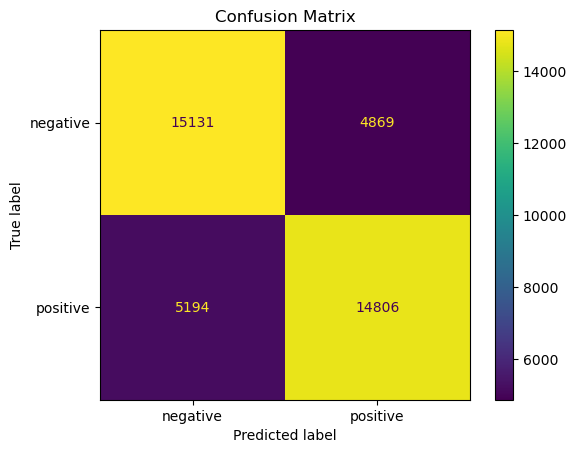

In [143]:
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
fig, ax = plt.subplots()
disp.plot(ax=ax)
plt.title('Confusion Matrix')
plt.show()

In [145]:

examples = [
' good',
'I hate this ',

]
ex_vec = tfidf.transform(examples)
print(pd.DataFrame({'text': examples, 'pred': clf.predict(ex_vec)}))

           text      pred
0          good  positive
1  I hate this   negative
